In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from StatTools.experimental.augmentation.perturbations import (
    add_noise,
    add_poisson_gaps,
)
from StatTools.experimental.analysis.tools import get_extra_h_dfa
from StatTools.experimental.synthesis.tools import adjust_hurst_to_range, reverse_hurst_adjustment
import math

from kalman_experiments import (
    get_signal,
    get_r_list,
    apply_kalman_filter,
)

### Experimental variables

| Variable              | Value                                     |
|-------------------------|----------------------------------------------|
| $ H $                 | $1/2$ to $3.5$, step is $1/4$              |
| Length of the forming filter, s   | open length |
| Order of the Kalman filter, r   | 2, 4, 8                                          |
| SNR     | $0.5, 1, 2$  |

In [3]:
H_LIST = np.arange(0.5, 3.75, 0.25)
TRJ_LEN_POW = 14
TRJ_LEN = 2**TRJ_LEN_POW

In [4]:
markers = [
    "o",  # circle
    "v",  # triangle_down
    "^",  # triangle_up
    "<",  # triangle_left
    ">",  # triangle_right
    "s",  # square
    "p",  # pentagon
    "*",  # star
    "h",  # hexagon
]

axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14
title_fontsize = 16

## Signal synthesis

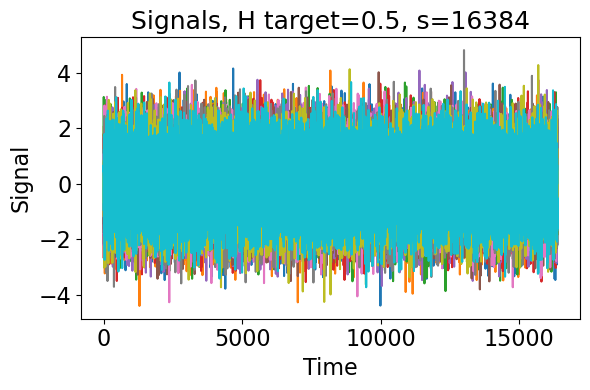

/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


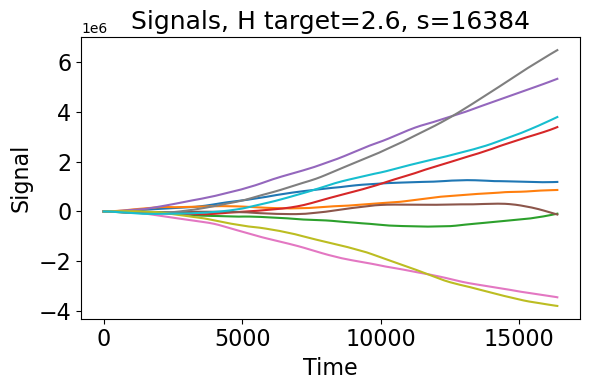

In [10]:
h = 0.5
s = TRJ_LEN
plt.figure(figsize=(6, 4))
for _ in range(10):
    signal = get_signal(h, TRJ_LEN, s)
    plt.plot(signal)

plt.title(f"Signals, H target={h}, s={s}", fontdict={"fontsize": 18})
plt.xlabel("Time", fontsize=16)
plt.ylabel("Signal", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig(f"./out/signals_{h}.svg")
plt.show()

h = 2.6
s = TRJ_LEN
plt.figure(figsize=(6, 4))
for _ in range(10):
    signal = get_signal(h, TRJ_LEN, s)
    plt.plot(signal)

plt.title(f"Signals, H target={h}, s={s}", fontdict={"fontsize": 18})
plt.xlabel("Time", fontsize=16)
plt.ylabel("Signal", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig(f"./out/signals_{h}.svg")
plt.show()

## Estimation of the synthesis error

In [11]:
test_df = pd.DataFrame(
    columns=[
        "H_target",
        "H_signal",
        "signal_len",
        "s",
    ]
)

In [15]:
s = TRJ_LEN
for h in H_LIST:
    for _ in tqdm(range(15)):
        signal = get_signal(h, TRJ_LEN, s)
        h_signal = get_extra_h_dfa(signal)
        test_df.loc[len(test_df)] = [
            h,
            h_signal,
            len(signal),
            s,
        ]

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
  7%|▋         | 1/15 [00:02<00:37,  2.66s/it]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
 13%|█▎        | 2/15 [00:05<00:34,  2.68s/it]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
 20%|██        | 3/15 [00:08<00:32,  2.69s/it]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
 27%|██▋       | 4/15 [00:10<00:29,  2.70s/it]/opt/conda/lib/python3.11/site-packages/StatTools/gene

In [16]:
test_df["H_gen_diff"] = abs(test_df["H_target"] - test_df["H_signal"])

In [17]:
test_df

,H_target,H_signal,signal_len,s,H_gen_diff
0,0.5,0.471656,16384.0,16384.0,0.028344
1,0.5,0.504204,16384.0,16384.0,0.004204
2,0.5,0.509779,16384.0,16384.0,0.009779
3,0.5,0.513498,16384.0,16384.0,0.013498
4,0.5,0.526140,16384.0,16384.0,0.026140
...,...,...,...,...,...
261,3.5,3.496047,16384.0,16384.0,0.003953
262,3.5,3.489703,16384.0,16384.0,0.010297
263,3.5,3.488679,16384.0,16384.0,0.011321
264,3.5,3.463679,16384.0,16384.0,0.036321


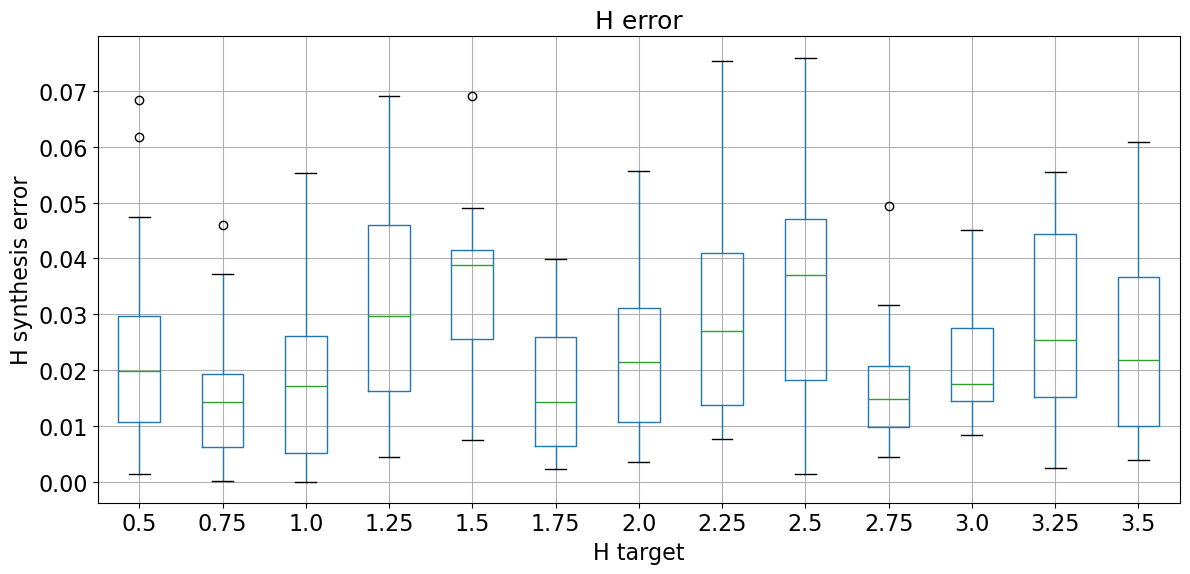

In [19]:
ax = test_df.boxplot(column="H_gen_diff", by="H_target", figsize=(12, 6))
plt.title("H error", fontdict={"fontsize": 18})
plt.suptitle("")
plt.xlabel("H target", fontsize=16)
plt.ylabel("H synthesis error", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("./out/H_synthesis_error.svg")
plt.show()

## Experiment-Synthetics

### Gaps

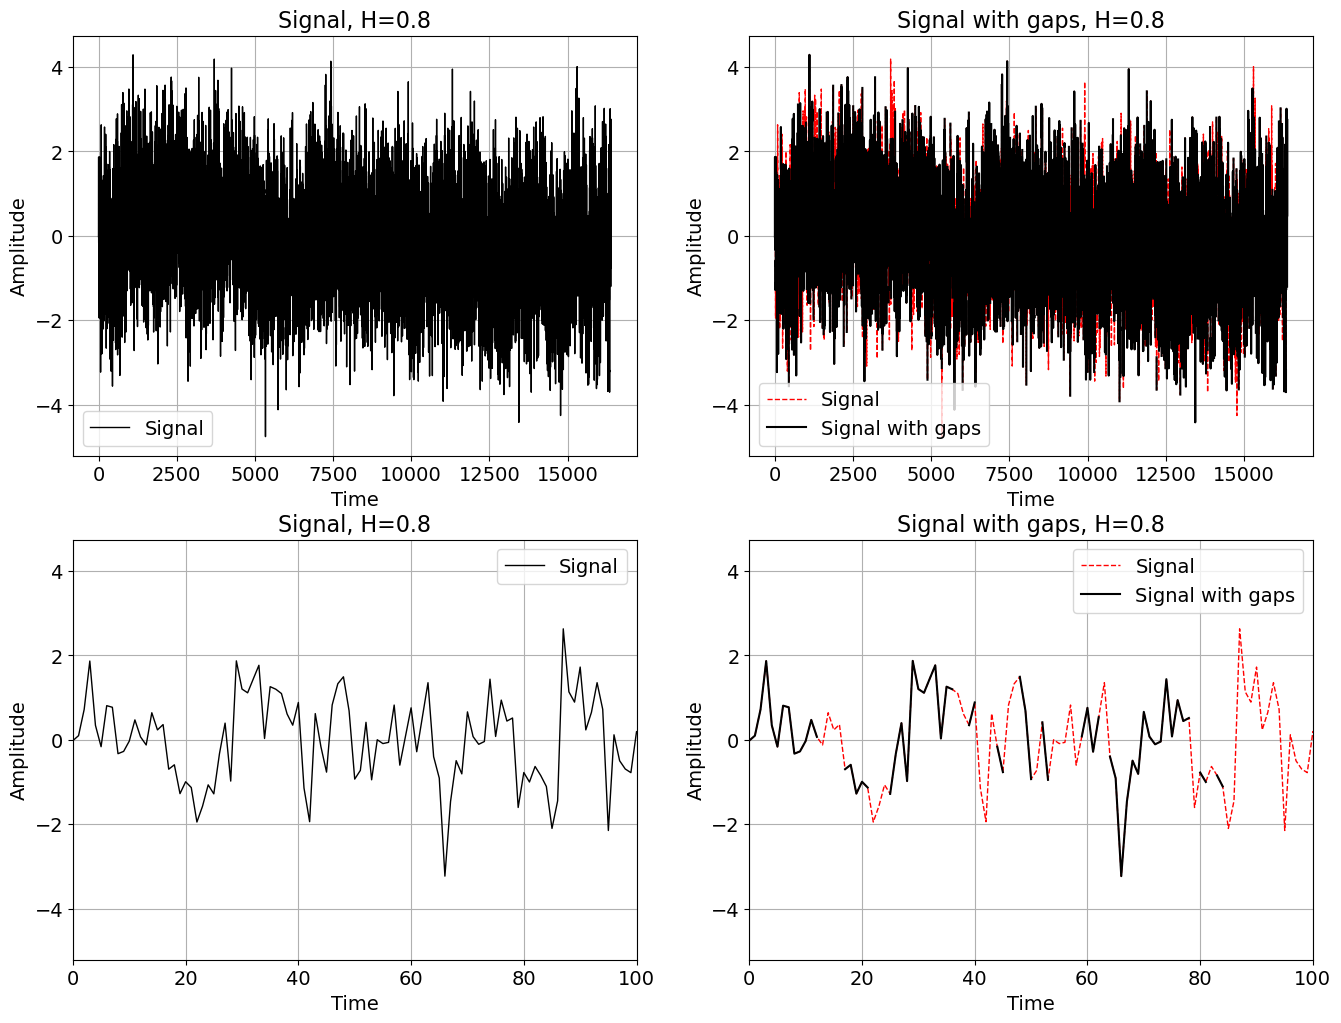

In [20]:
s = TRJ_LEN
h = 0.8
generated_signal = get_signal(h, TRJ_LEN, s)
gap_rate = 0.2
length_rate = 2.0
gaps_signal, gaps = add_poisson_gaps(generated_signal, gap_rate, length_rate)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 2)
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linestyle="--",
    linewidth=1,
)
plt.plot(gaps_signal, label="Signal with gaps", color="black")
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal with gaps, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 3)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.xlim(0, 100)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 4)
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linestyle="--",
    linewidth=1,
)
plt.plot(gaps_signal, label="Signal with gaps", color="black")
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.xlim(0, 100)
plt.title(f"Signal with gaps, H={h}", fontdict={"fontsize": title_fontsize})
plt.show()


In [21]:
metrics_df = pd.DataFrame(
    columns=[
        "H_target",
        "H_signal",
        "H_restored",
        "signal_len",
        "s",
        "r",
        "gap_rate",
        "length_rate",
        "SE",
    ]
)

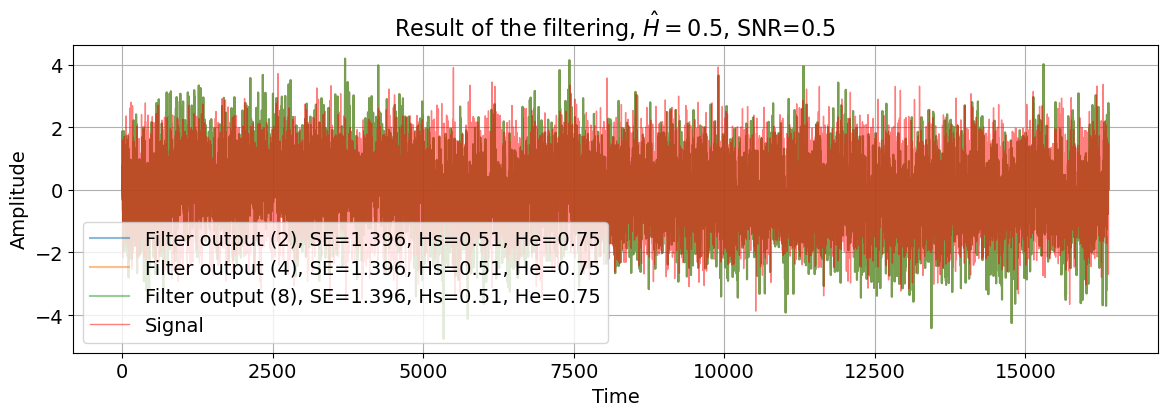

H=0.5, SE (order 2): 1.396+-0.000
H=0.5, SE (order 4): 1.396+-0.000
H=0.5, SE (order 8): 1.396+-0.000


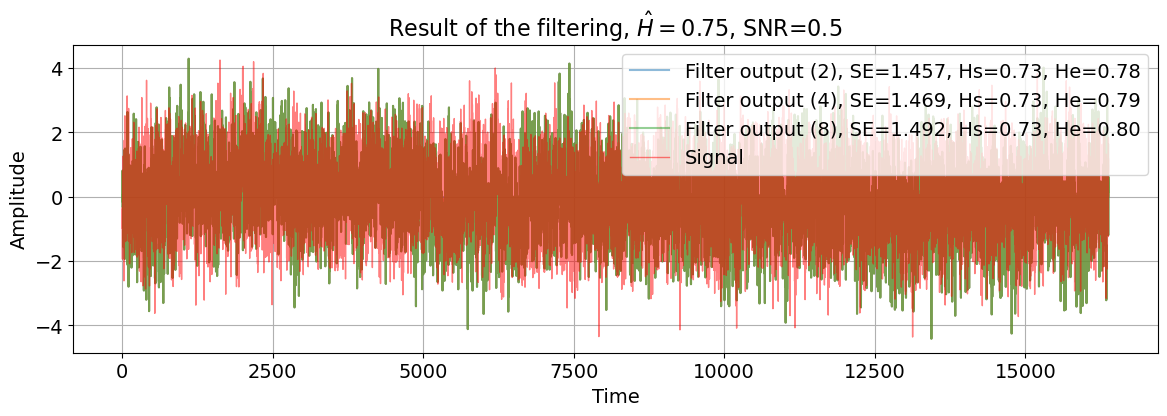

H=0.75, SE (order 2): 1.457+-0.000
H=0.75, SE (order 4): 1.469+-0.000
H=0.75, SE (order 8): 1.492+-0.000


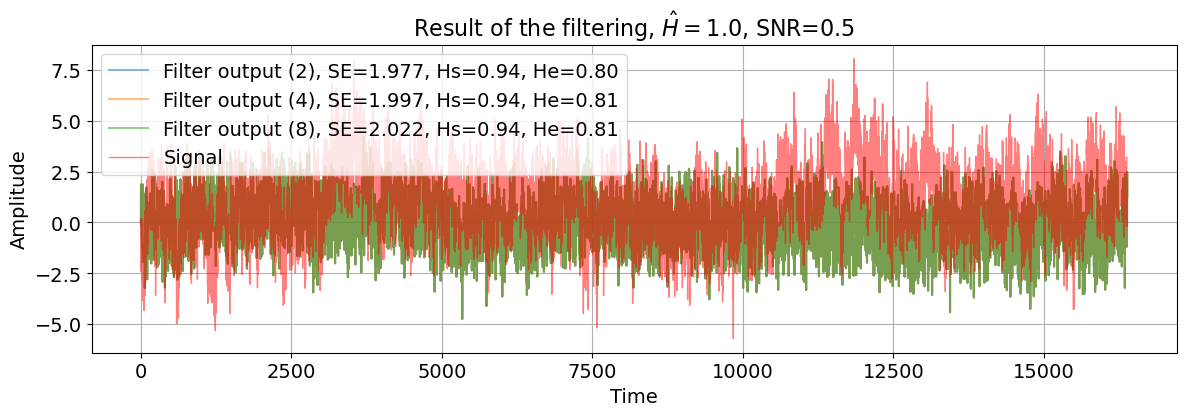

H=1.0, SE (order 2): 1.977+-0.000
H=1.0, SE (order 4): 1.997+-0.000
H=1.0, SE (order 8): 2.022+-0.000


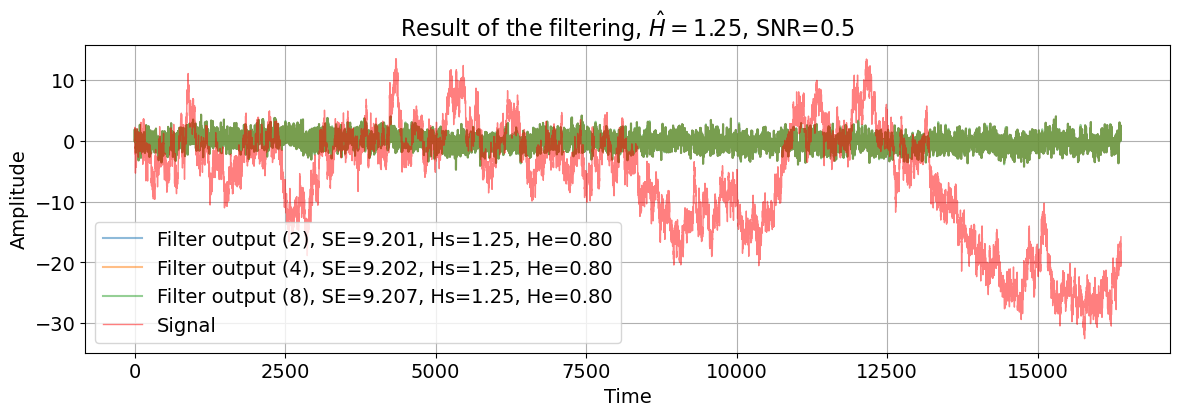

H=1.25, SE (order 2): 9.201+-0.000
H=1.25, SE (order 4): 9.202+-0.000
H=1.25, SE (order 8): 9.207+-0.000


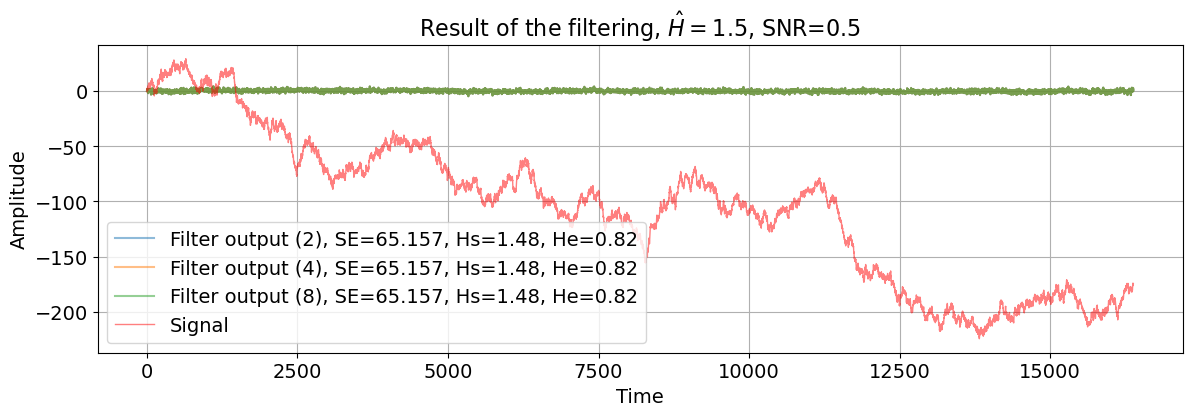

H=1.5, SE (order 2): 65.157+-0.000
H=1.5, SE (order 4): 65.157+-0.000
H=1.5, SE (order 8): 65.157+-0.000


/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


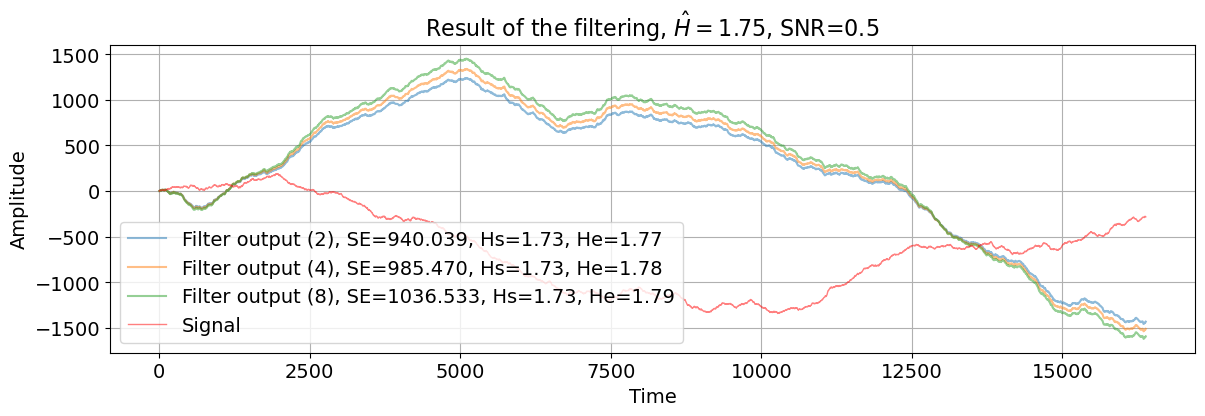

H=1.75, SE (order 2): 940.039+-0.000
H=1.75, SE (order 4): 985.470+-0.000
H=1.75, SE (order 8): 1036.533+-0.000


/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


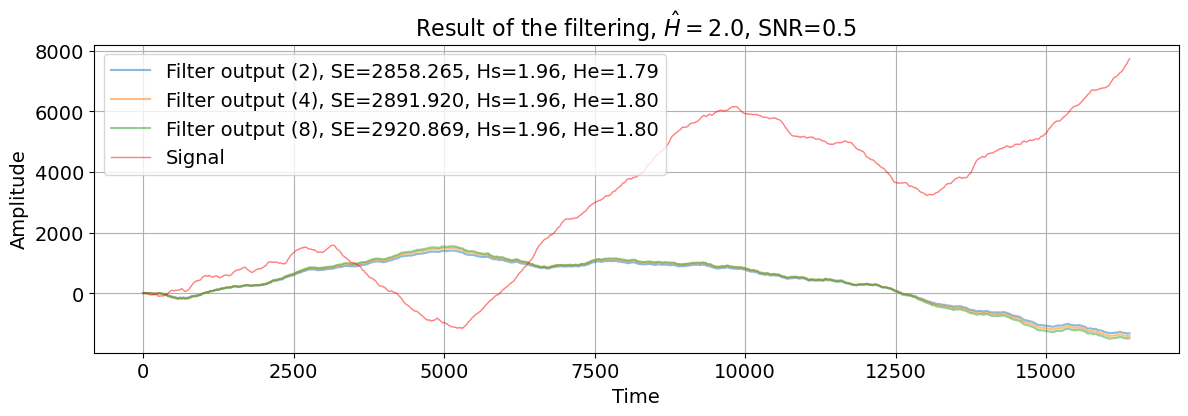

H=2.0, SE (order 2): 2858.265+-0.000
H=2.0, SE (order 4): 2891.920+-0.000
H=2.0, SE (order 8): 2920.869+-0.000


/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


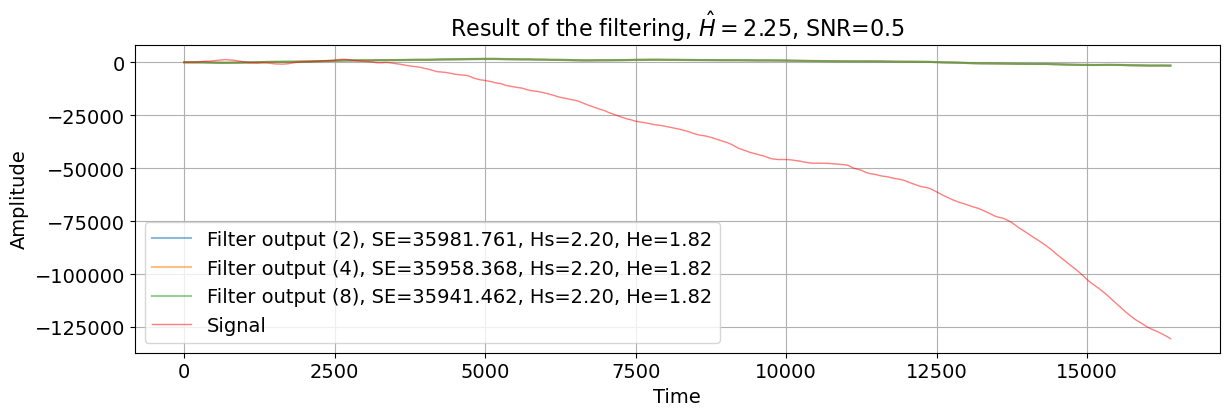

H=2.25, SE (order 2): 35981.761+-0.000
H=2.25, SE (order 4): 35958.368+-0.000
H=2.25, SE (order 8): 35941.462+-0.000


/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


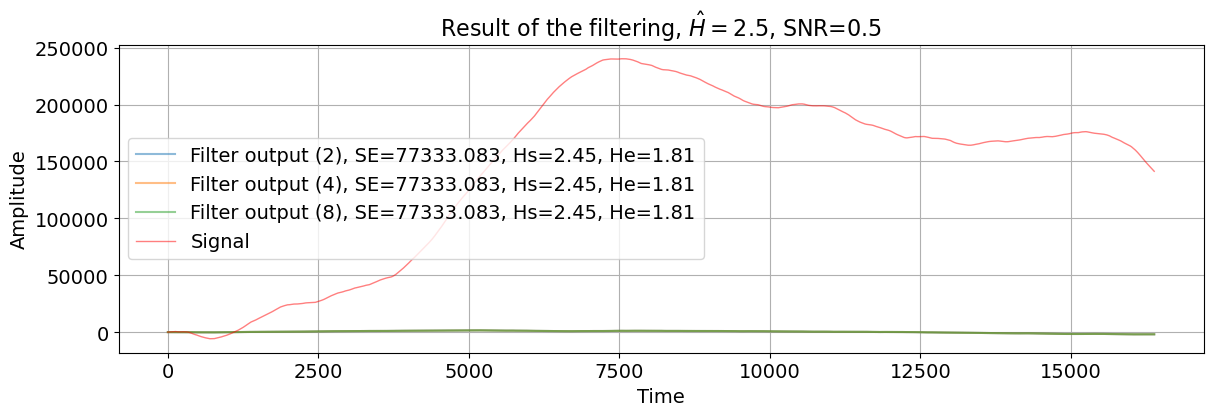

H=2.5, SE (order 2): 77333.083+-0.000
H=2.5, SE (order 4): 77333.083+-0.000
H=2.5, SE (order 8): 77333.083+-0.000


In [25]:
# one process version with plot
s = TRJ_LEN
axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14
title_fontsize = 16
n = 1
gap_rate = 0.2
length_rate = 2.0
for h in H_LIST[0:9]:
    se_dict = {}
    for r in get_r_list():
        se_dict[r] = []

    for i in range(n):
        signal = get_signal(h, TRJ_LEN, s, normalize=False)
        if i == 0:
            plt.figure(figsize=(14, 4))
        new_signal = signal
        if get_extra_h_dfa(signal) > 1.5:
            new_signal = np.diff(signal)
        gaps_signal, _ = add_poisson_gaps(generated_signal, gap_rate, length_rate)

        r_list = get_r_list()
        h_s = get_extra_h_dfa(signal)
        for r in r_list:
            estimated_signal = apply_kalman_filter(
                new_signal, gaps_signal, h, r
            )
            if get_extra_h_dfa(signal) > 1.5:
                estimated_signal = np.cumsum(estimated_signal)

            se = np.nanstd(signal[0 : len(estimated_signal)] - estimated_signal)
            se_dict[r].append(se)

            h_est = get_extra_h_dfa(estimated_signal)
            if i == 0:
                plt.plot(
                    estimated_signal,
                    label=f"Filter output ({r}), SE={se:.3f}, Hs={h_s:.2f}, He={h_est:.2f}",
                    alpha=0.5,
                )

            metrics_df.loc[len(metrics_df)] = [
                h,
                h_s,
                h_est,
                len(signal),
                s,
                r,
                gap_rate,
                length_rate,
                se,
            ]

        if i == 0:
            plt.plot(
                signal,
                label="Signal",
                color="red",
                alpha=0.5,
                linewidth=1,
            )
            plt.xlabel("Time", fontsize=axis_fontsize)
            plt.ylabel("Amplitude", fontsize=axis_fontsize)
            # plt.xlim(2000, 2100)
            plt.legend(fontsize=legend_fontsize)
            plt.tick_params(labelsize=label_fontsize)
            plt.title(
                f"Result of the filtering, $\\hat{{H}}=${h}, gaps length rate={length_rate}",
                fontdict={"fontsize": title_fontsize},
            )
            plt.grid(True)
            plt.show()

    for k, v in se_dict.items():
        print(f"H={h}, SE (order {k}): {np.mean(v):.3f}+-{np.std(v):.3f}")

In [26]:
metrics_df.to_csv("./out/kalman-kasdin-gaps.csv", index=False)

#### Analysis

In [27]:
metrics_df = pd.read_csv("./out/kalman-kasdin-gaps.csv")
metrics_df.head()

,H_target,H_signal,H_restored,signal_len,s,r,gap_rate,length_rate,SE
0,0.50,0.510208,0.746558,16384.0,16384.0,2.0,0.2,2.0,1.395685
1,0.50,0.510208,0.746558,16384.0,16384.0,4.0,0.2,2.0,1.395685
2,0.50,0.510208,0.746558,16384.0,16384.0,8.0,0.2,2.0,1.395685
3,0.75,0.734819,0.776782,16384.0,16384.0,2.0,0.2,2.0,1.456856
4,0.75,0.734819,0.790996,16384.0,16384.0,4.0,0.2,2.0,1.468759


In [28]:
metrics_df["H_restore_diff"] = abs(metrics_df["H_signal"] - metrics_df["H_restored"])
metrics_df["H_gen_diff"] = abs(metrics_df["H_target"] - metrics_df["H_signal"])

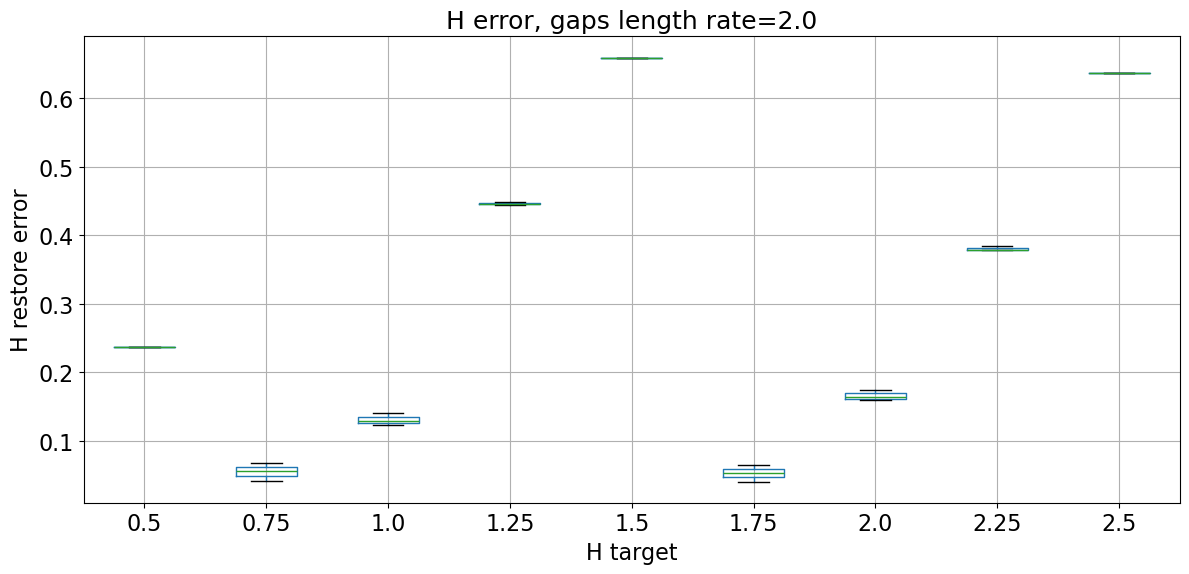

In [32]:
for length_rate in metrics_df["length_rate"].unique():
    part_metrics_df = metrics_df[metrics_df["length_rate"] == length_rate]
    ax = part_metrics_df.boxplot(column="H_restore_diff", by="H_target", figsize=(12, 6))
    plt.title(f"H error, gaps length rate={length_rate}", fontdict={"fontsize": 18})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=16)
    plt.ylabel("H restore error", fontsize=16)
    plt.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()

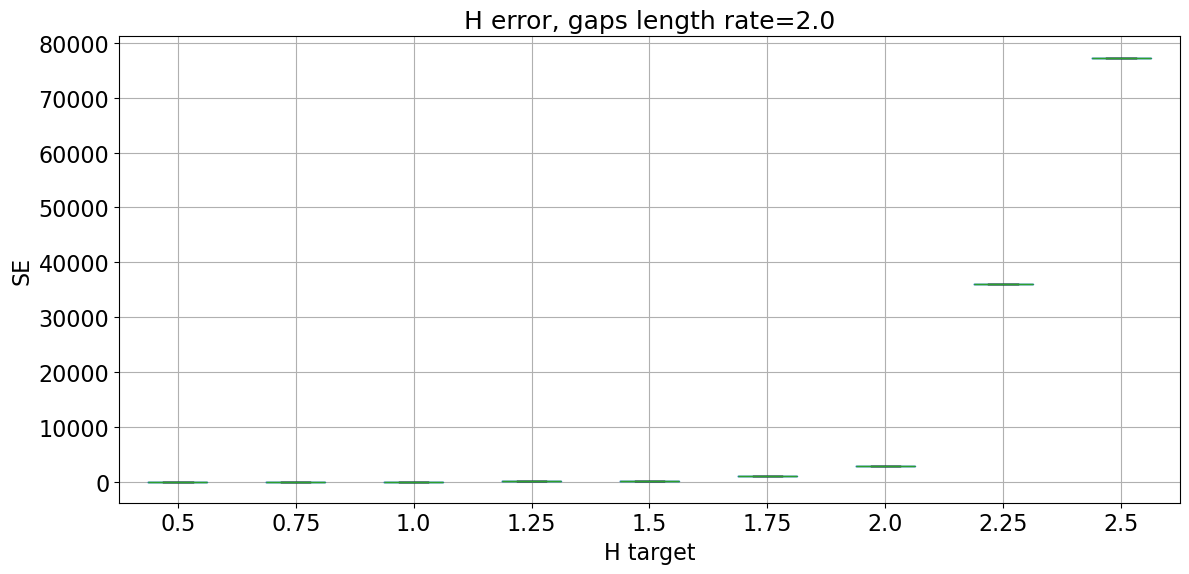

In [33]:
for length_rate in metrics_df["length_rate"].unique():
    part_metrics_df = metrics_df[metrics_df["length_rate"] == length_rate]
    ax = part_metrics_df.boxplot(column="SE", by="H_target", figsize=(12, 6))
    plt.title(f"H error, gaps length rate={length_rate}", fontdict={"fontsize": 18})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=16)
    plt.ylabel("SE", fontsize=16)
    plt.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()

### Noise

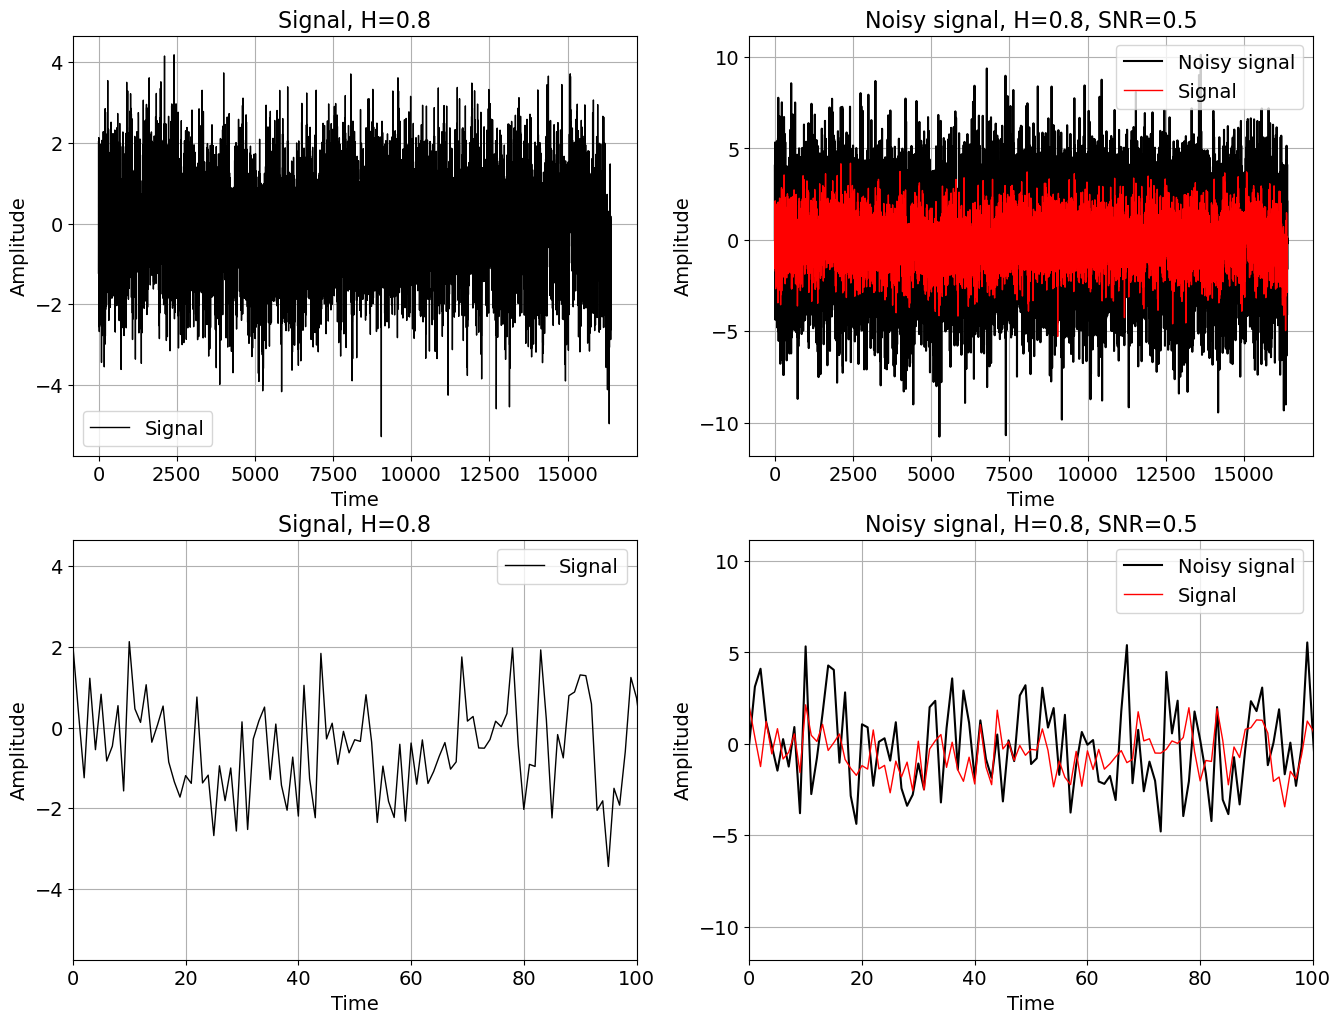

In [4]:
s = TRJ_LEN
h = 0.8
generated_signal = get_signal(h, TRJ_LEN, s)
snr = 0.5
noisy_signal, _ = add_noise(generated_signal, snr)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 2)
plt.plot(noisy_signal, label="Noisy signal", color="black")
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linewidth=1,
)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Noisy signal, H={h}, SNR={snr}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 3)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.xlim(0, 100)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 4)
plt.plot(noisy_signal, label="Noisy signal", color="black")
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linewidth=1,
)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.xlim(0, 100)
plt.title(f"Noisy signal, H={h}, SNR={snr}", fontdict={"fontsize": title_fontsize})
plt.show()

In [7]:
metrics_df = pd.DataFrame(
    columns=[
        "H_target",
        "H_signal",
        "H_restored",
        "signal_len",
        "s",
        "r",
        "SNR",
        "SE",
    ]
)

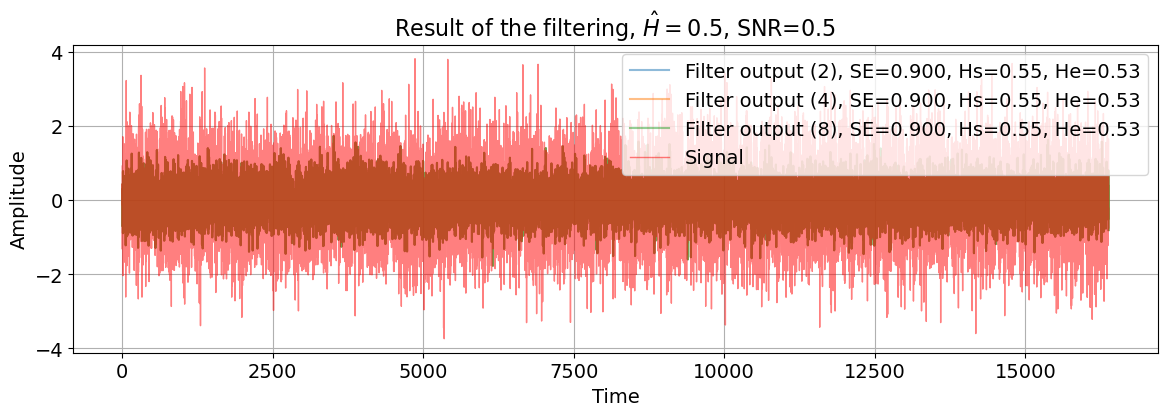

H=0.5, SE (order 2): 0.894+-0.006
H=0.5, SE (order 4): 0.894+-0.006
H=0.5, SE (order 8): 0.894+-0.006


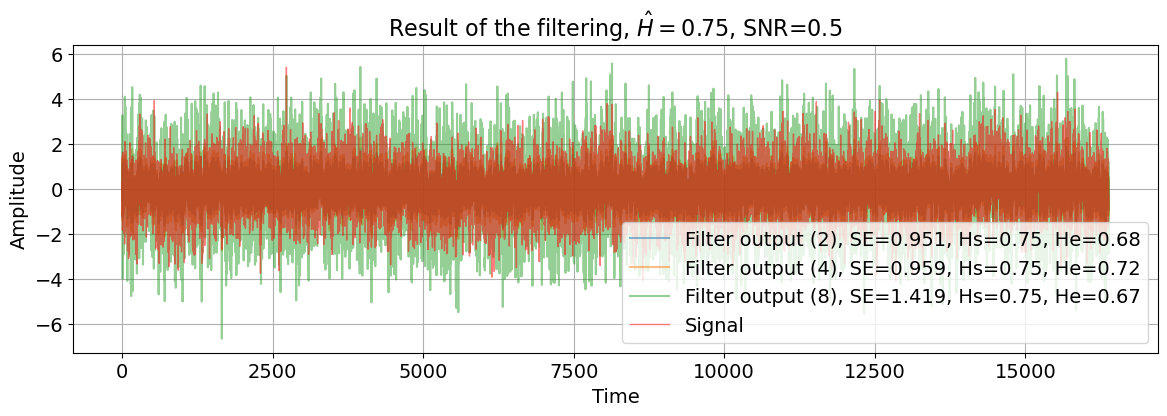

H=0.75, SE (order 2): 0.953+-0.002
H=0.75, SE (order 4): 0.961+-0.002
H=0.75, SE (order 8): 1.421+-0.003


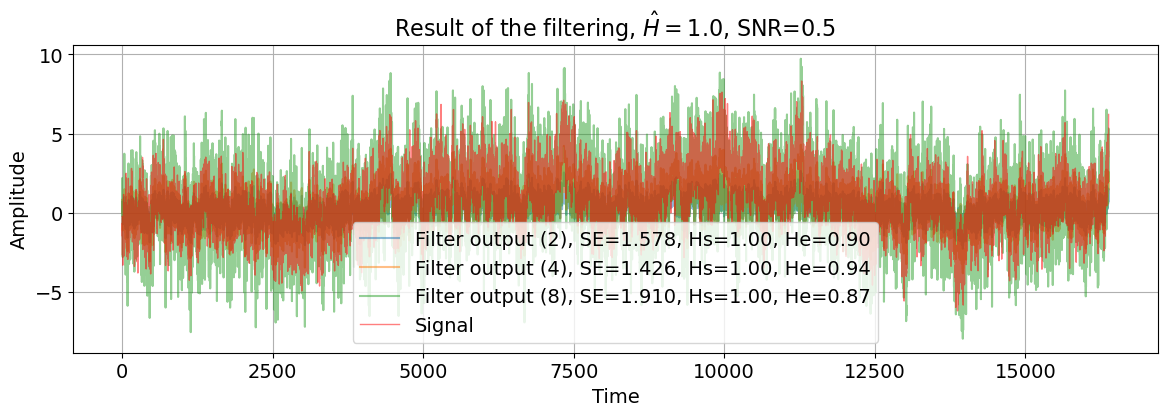

H=1.0, SE (order 2): 1.455+-0.076
H=1.0, SE (order 4): 1.350+-0.047
H=1.0, SE (order 8): 1.859+-0.031


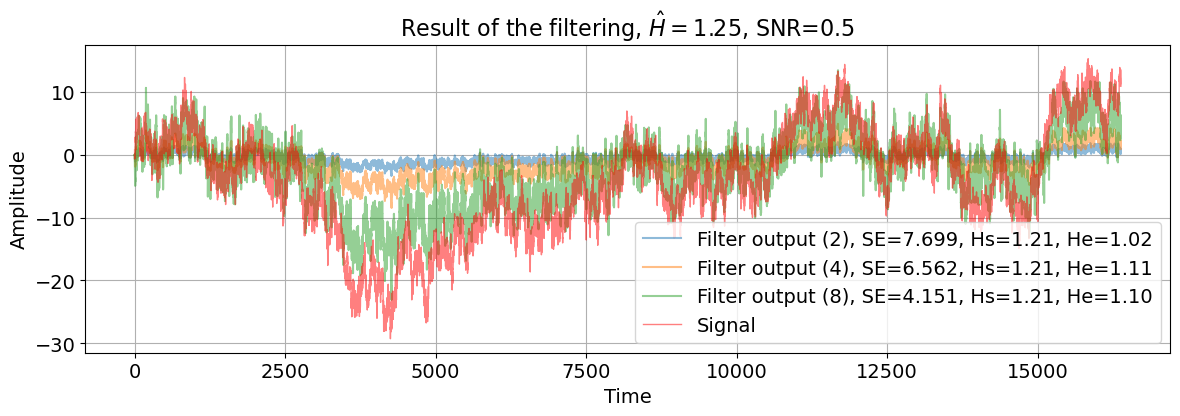

H=1.25, SE (order 2): 8.120+-4.256
H=1.25, SE (order 4): 7.153+-4.230
H=1.25, SE (order 8): 4.940+-2.739


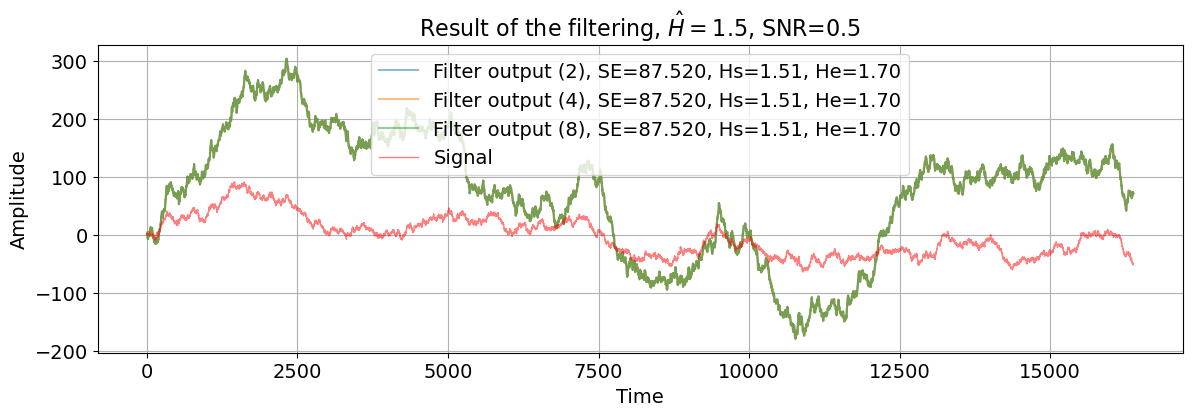

H=1.5, SE (order 2): 25.489+-31.021
H=1.5, SE (order 4): 25.489+-31.021
H=1.5, SE (order 8): 25.489+-31.021


/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


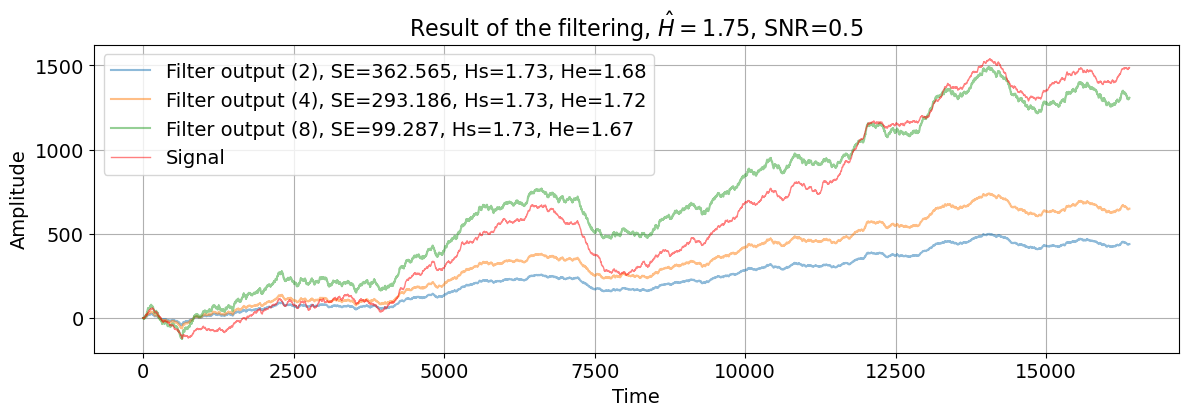

/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:12

H=1.75, SE (order 2): 247.494+-139.235
H=1.75, SE (order 4): 202.940+-117.481
H=1.75, SE (order 8): 124.581+-30.089


/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


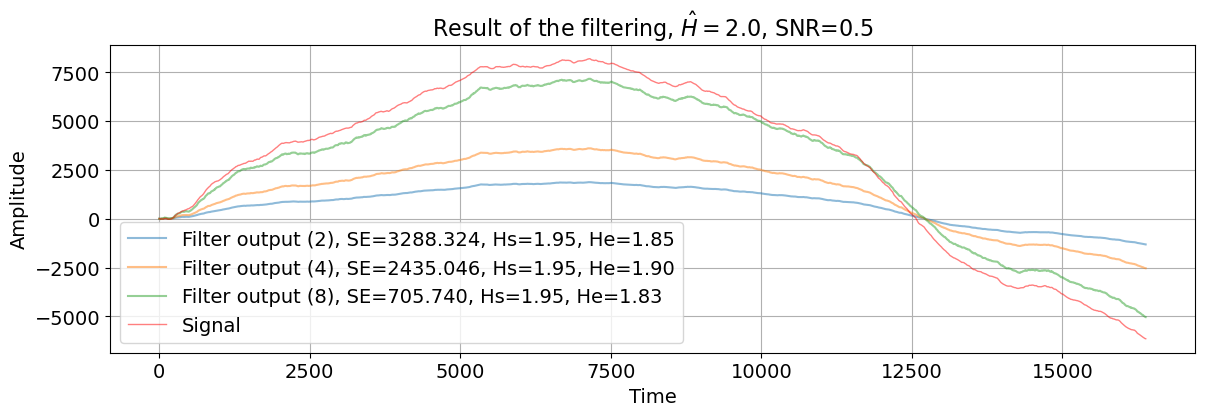

/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:12

H=2.0, SE (order 2): 2098.140+-1113.176
H=2.0, SE (order 4): 1509.860+-792.936
H=2.0, SE (order 8): 469.272+-169.094


/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


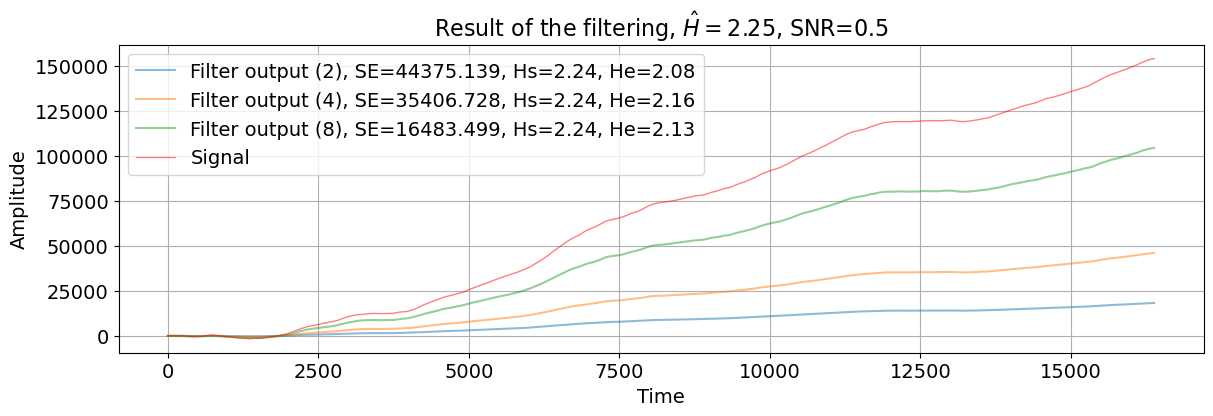

/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:12

H=2.25, SE (order 2): 29091.823+-10125.838
H=2.25, SE (order 4): 22051.959+-8000.268
H=2.25, SE (order 8): 9357.113+-3860.584


/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


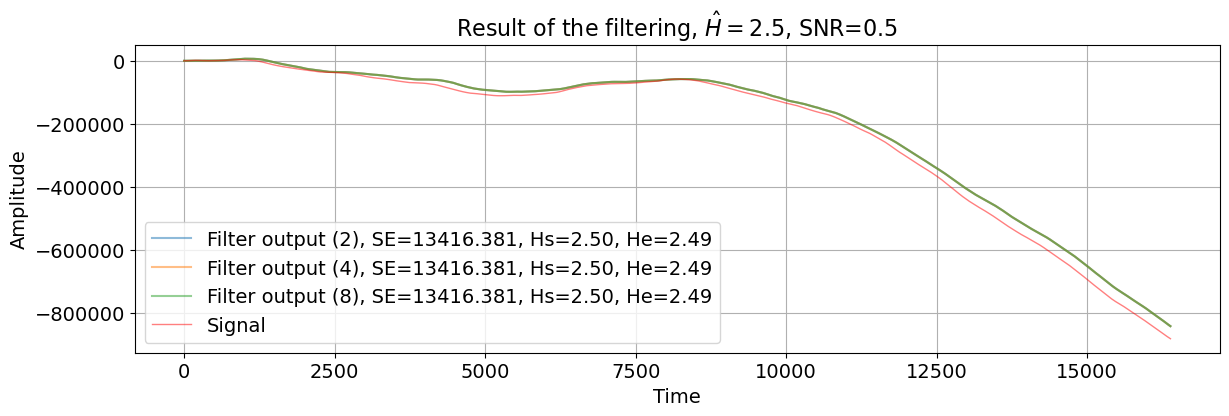

/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:12

H=2.75, SE (order 2): 1944950.036+-1234080.633
H=2.75, SE (order 4): 1567886.765+-948050.277
H=2.75, SE (order 8): 556698.716+-299899.166


/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


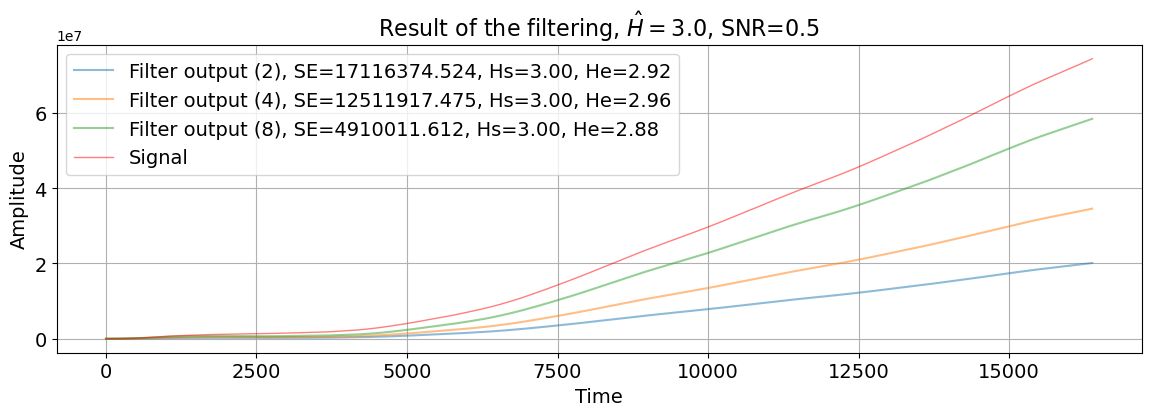

/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:12

H=3.0, SE (order 2): 23175524.483+-21194595.830
H=3.0, SE (order 4): 16453105.347+-15125271.943
H=3.0, SE (order 8): 4946051.782+-3577204.391


/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


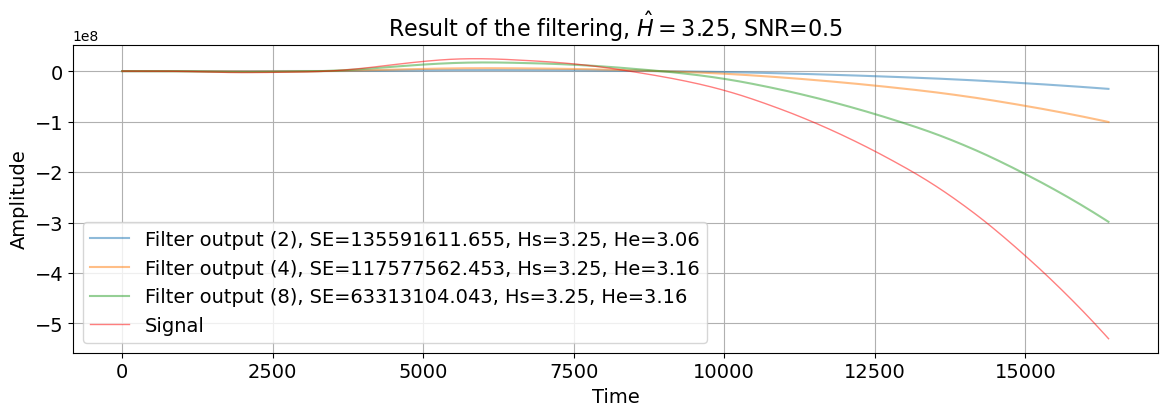

/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:12

H=3.25, SE (order 2): 214467841.587+-141633252.190
H=3.25, SE (order 4): 178427300.823+-118453828.845
H=3.25, SE (order 8): 85921243.844+-55826907.714


/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


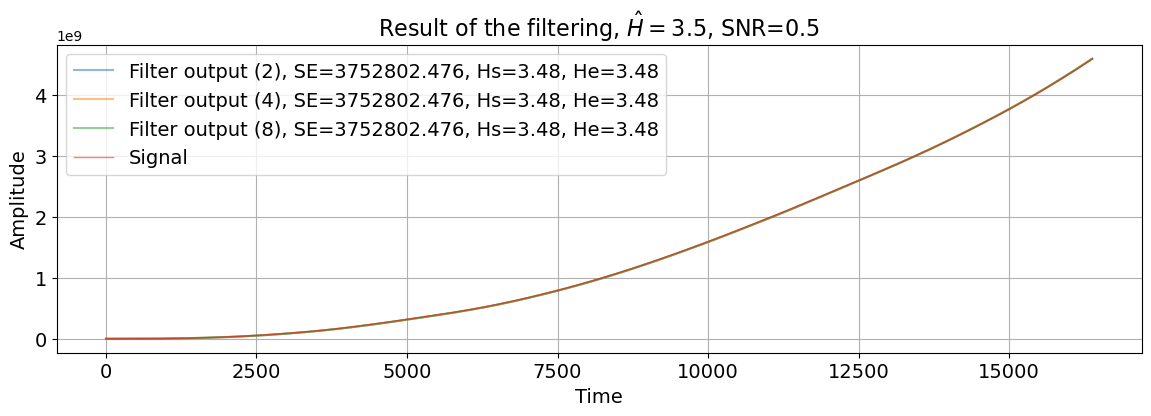

/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
/home/jovyan/git/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:12

H=3.5, SE (order 2): 16576761.721+-19087488.158
H=3.5, SE (order 4): 16576761.721+-19087488.158
H=3.5, SE (order 8): 16576761.721+-19087488.158


In [8]:
# one process version with plot
s = TRJ_LEN
axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14
title_fontsize = 16
snr = 0.5
n = 5
for h in H_LIST:
    se_dict = {}
    for r in get_r_list():
        se_dict[r] = []

    for i in range(n):
        signal = get_signal(h, TRJ_LEN, s, normalize=False)
        if i == 0:
            plt.figure(figsize=(14, 4))
        adjusted_signal, applied_steps = adjust_hurst_to_range(signal)
        noisy_signal, noise = add_noise(adjusted_signal, ratio=snr)
        r_list = get_r_list()
        h_s = get_extra_h_dfa(signal)
        for r in r_list:
            estimated_signal = apply_kalman_filter(
                adjusted_signal, noisy_signal, h, r, noise
            )
            estimated_signal = reverse_hurst_adjustment(estimated_signal, applied_steps)
            se = np.nanstd(signal[0 : len(estimated_signal)] - estimated_signal)
            se_dict[r].append(se)

            h_est = get_extra_h_dfa(estimated_signal)
            if i == 0:
                plt.plot(
                    estimated_signal,
                    label=f"Filter output ({r}), SE={se:.3f}, Hs={h_s:.2f}, He={h_est:.2f}",
                    alpha=0.5,
                )

            metrics_df.loc[len(metrics_df)] = [
                h,
                h_s,
                h_est,
                len(signal),
                s,
                r,
                snr,
                se,
            ]

        if i == 0:
            plt.plot(
                signal,
                label="Signal",
                color="red",
                alpha=0.5,
                linewidth=1,
            )
            plt.xlabel("Time", fontsize=axis_fontsize)
            plt.ylabel("Amplitude", fontsize=axis_fontsize)
            # plt.xlim(2000, 2100)
            plt.legend(fontsize=legend_fontsize)
            plt.tick_params(labelsize=label_fontsize)
            plt.title(
                f"Result of the filtering, $\\hat{{H}}=${h}, SNR={snr}",
                fontdict={"fontsize": title_fontsize},
            )
            plt.grid(True)
            plt.show()

    for k, v in se_dict.items():
        print(f"H={h}, SE (order {k}): {np.mean(v):.3f}+-{np.std(v):.3f}")

In [9]:
metrics_df.to_csv("./out/kalman-kasdin-noise.csv", index=False)

#### Analysis

In [5]:
metrics_df = pd.read_csv("./out/kalman-kasdin-noise.csv")
metrics_df.head()

,H_target,H_signal,H_restored,signal_len,s,r,SNR,SE
0,0.5,0.547727,0.528246,16384.0,16384.0,2.0,0.5,0.900469
1,0.5,0.547727,0.528246,16384.0,16384.0,4.0,0.5,0.900469
2,0.5,0.547727,0.528246,16384.0,16384.0,8.0,0.5,0.900469
3,0.5,0.500329,0.505663,16384.0,16384.0,2.0,0.5,0.890258
4,0.5,0.500329,0.505663,16384.0,16384.0,4.0,0.5,0.890258


In [6]:
metrics_df["H_restore_diff"] = abs(metrics_df["H_signal"] - metrics_df["H_restored"])
metrics_df["H_gen_diff"] = abs(metrics_df["H_target"] - metrics_df["H_signal"])

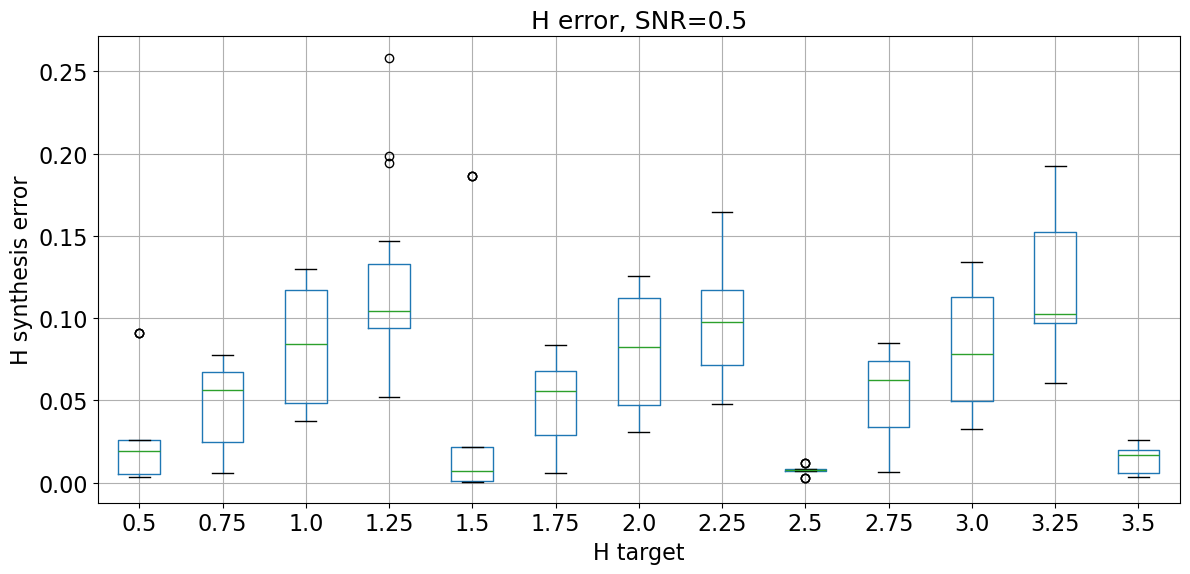

In [7]:
for snr in metrics_df["SNR"].unique():
    part_metrics_df = metrics_df[metrics_df["SNR"] == snr]
    ax = part_metrics_df.boxplot(column="H_restore_diff", by="H_target", figsize=(12, 6))
    plt.title(f"H error, SNR={snr}", fontdict={"fontsize": 18})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=16)
    plt.ylabel("H synthesis error", fontsize=16)
    plt.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()

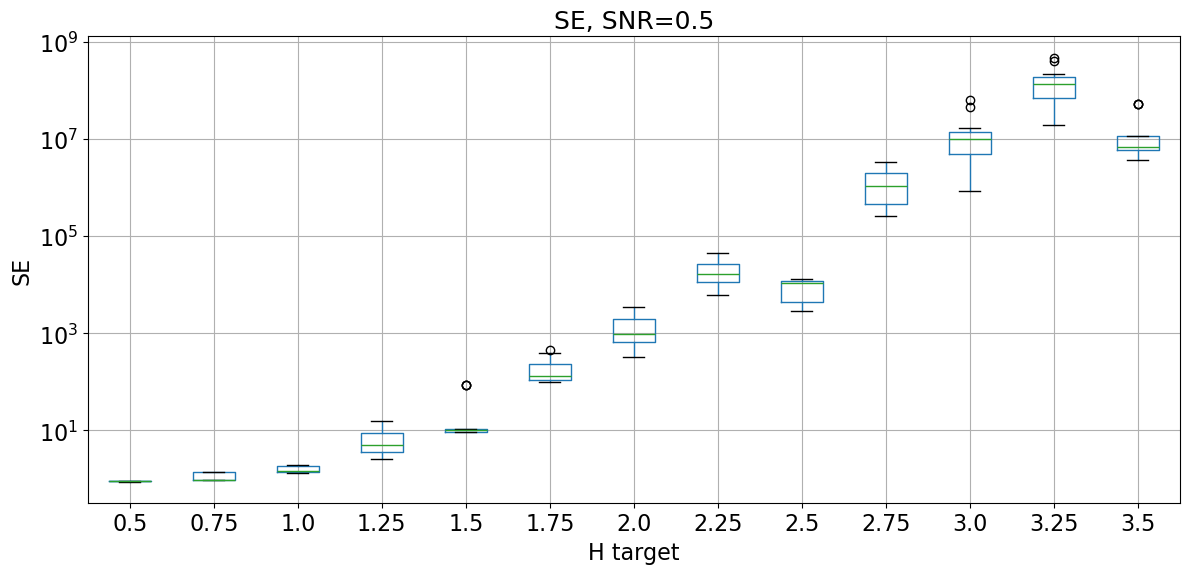

In [10]:
for snr in metrics_df["SNR"].unique():
    part_metrics_df = metrics_df[metrics_df["SNR"] == snr]
    ax = part_metrics_df.boxplot(column="SE", by="H_target", figsize=(12, 6))
    plt.title(f"SE, SNR={snr}", fontdict={"fontsize": 18})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=16)
    plt.ylabel("SE", fontsize=16)
    plt.yscale("log")
    plt.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()